In [1]:
import dataset as dtst
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

C:\Users\Willi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Load the model
from model import DisentangleVAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DisentangleVAE.init_model(device)

# load model parameters
# pytorch uses .pt file to save model parameters.
model_path = 'result/models/disvae-nozoth_epoch.pt'  
# setting cuda if cuda is available, which will speed up the computation.
model.load_model(model_path, map_location=device)

In [3]:
# Load the dataset
shift_low = -6
shift_high = 6
num_bar = 2
contain_chord = True
fns = dtst.collect_data_fns()
dataset = dtst.wrap_dataset(fns, np.arange(len(fns)), shift_low, shift_high,
                            num_bar=num_bar, contain_chord=contain_chord)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

The folder contains 886 .npz files.
Selected 858 files, all are in duple meter.


In [4]:
# Generate a random chord
# For now, uniformly sample a triad in root position. At actual training time, consider basing the sample distribution on noised frequencies. 
def gen_chord():
    out = torch.zeros(8, 36)
    for i in range(out.shape[0]):
        out[i] = gen_chord_step()
    return out

def gen_chord_step():
    root = torch.randint(high=12, size=(1, ))
    bass = 0
    
    out = torch.zeros(1, 36)
    out[0, root] = 1
    out[0, bass + 24] = 1
    
    out[0, 12 + root] = 1
    out[0, 12 + (root + 7) % 12] = 1

    if random.random() < 0.5:
        # Minor
        out[0, 12 + (root + 4) % 12] = 1
    else:
        out[0, 12 + (root + 3) % 12] = 1

    return out

gen_chord()


tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0

In [5]:
# Nearest neighbours
# An naive rule set to apply HST. Consider using a learned one.
def hst_nn(notes, chord_mat):
    notes_out = []
    for i in range(chord_mat.shape[0]):
        notes_out += apply_nn_step(notes, chord_mat[i: i+1, :], i)
    return notes_out

def apply_nn_step(notes, chord, step, quant_size=1):
    # Filter out notes starting in the window
    filtered_notes = []
    for note in notes:
        if note.start >= quant_size * step and note.start <= quant_size * (step + 1):
            filtered_notes.append(note)
    
    for note in filtered_notes:
        pitch_dist = 999
        pit_out = 0
        for pit in range(20, 100):
            # Is this pitch included in the chroma?
            if chord[0, 12 + pit % 12] == 0:
                continue
            dist = abs(note.pitch - pit)
            if dist < pitch_dist:
                pitch_dist = dist
                pit_out = pit
        note.pitch = pit_out
    return filtered_notes

melody, pr, pr_mat, ptree, chord = dataset[12]
_, notes = model.decoder.grid_to_pr_and_notes(ptree.squeeze(0).astype(int))
hst_nn(notes, gen_chord())

[Note(start=3.500000, end=4.000000, pitch=71, velocity=100),
 Note(start=4.000000, end=5.500000, pitch=56, velocity=100),
 Note(start=4.000000, end=4.500000, pitch=83, velocity=100),
 Note(start=4.000000, end=5.500000, pitch=56, velocity=100),
 Note(start=4.000000, end=4.500000, pitch=83, velocity=100),
 Note(start=4.250000, end=5.500000, pitch=59, velocity=100),
 Note(start=4.500000, end=5.250000, pitch=63, velocity=100),
 Note(start=4.500000, end=4.750000, pitch=80, velocity=100),
 Note(start=4.750000, end=6.000000, pitch=71, velocity=100),
 Note(start=5.000000, end=5.250000, pitch=76, velocity=100),
 Note(start=5.000000, end=5.250000, pitch=76, velocity=100),
 Note(start=5.500000, end=5.750000, pitch=84, velocity=100),
 Note(start=5.750000, end=6.000000, pitch=88, velocity=100),
 Note(start=6.000000, end=7.250000, pitch=57, velocity=100),
 Note(start=6.000000, end=7.250000, pitch=85, velocity=100),
 Note(start=6.000000, end=7.250000, pitch=57, velocity=100),
 Note(start=6.000000, en

0.26004733144915676 0.3800107473653786 0.3079440819821938


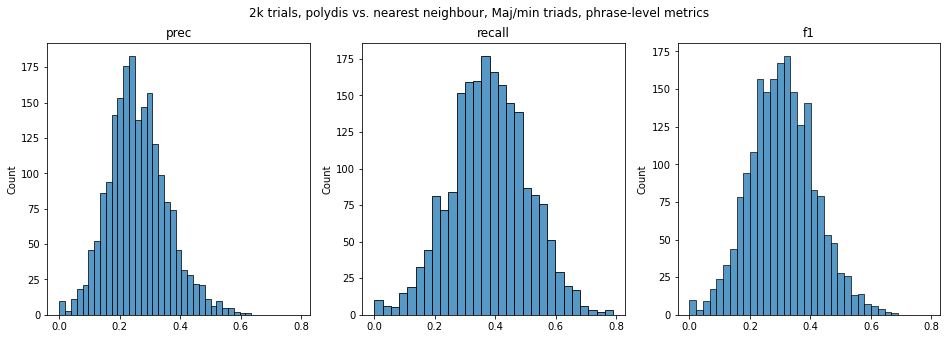

In [6]:
def prec_recall_f1(pred, ref):
    hit = 0
    n_pred = len(pred)
    n_true = len(ref)
    for note in pred:
        start = note.start
        end = note.end
        pit = note.pitch
        eject_idx = -1
        for idx, note_ref in enumerate(ref):
            if note_ref.start == start and note_ref.end == end and note_ref.pitch == pit:
                hit += 1
                eject_idx = idx
                break
        if eject_idx > -1:
            ref.pop(eject_idx)
    if n_pred == 0:
        prec = 1e-10
    else:
        prec = hit / n_pred + 1e-10
    if n_true == 0 :
        recall = 1e-10
    else:
        recall = hit / n_true + 1e-10
    f1 = 2 / (1 / prec + 1 / recall)
    return prec, recall, f1

def run_trial():
    n_trial = 2000
    precs = []
    recalls = []
    f1s = []

    iter = 0
    while True:
        for batch in loader:
            iter += 1
            if iter > n_trial:
                break

            melody, pr, pr_mat, ptree, _ = batch
            pr_mat = pr_mat[0]
            chord = gen_chord()
            chord_ = chord.unsqueeze(0)
            _, notes = model.decoder.grid_to_pr_and_notes(ptree[0].squeeze(0).numpy().astype(int))

            polydis_out = model.swap(pr_mat.float(), pr_mat.float(), chord_.float(), chord_.float(), fix_rhy=True, fix_chd=False)
            _, notes_polydis = model.decoder.grid_to_pr_and_notes(polydis_out.squeeze(0).astype(int))
            notes_rule = hst_nn(notes, chord)
            
            prec, recall, f1 = prec_recall_f1(notes_rule, notes_polydis)
            precs.append(prec)
            recalls.append(recall)
            f1s.append(f1)
        
        if iter > n_trial:
            break
    precs = np.array(precs)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    return precs, recalls, f1s

prec, recall, f1 = run_trial()
print(np.mean(prec), np.mean(recall), np.mean(f1))
out = {
    'prec': prec,
    'recall': recall,
    'f1': f1
}
torch.save(out, 'prec_recall_f1.hi')

data = torch.load('./prec_recall_f1.hi')

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(16,5))

fig.suptitle('2k trials, polydis vs. nearest neighbour, Maj/min triads, phrase-level metrics')
for idx, metric in enumerate(['prec', 'recall', 'f1']):
    sns.histplot(data[metric], ax=axes[idx])
    axes[idx].set_title(metric)

0.5059385823975892 0.7425046903184767 0.600243437345202


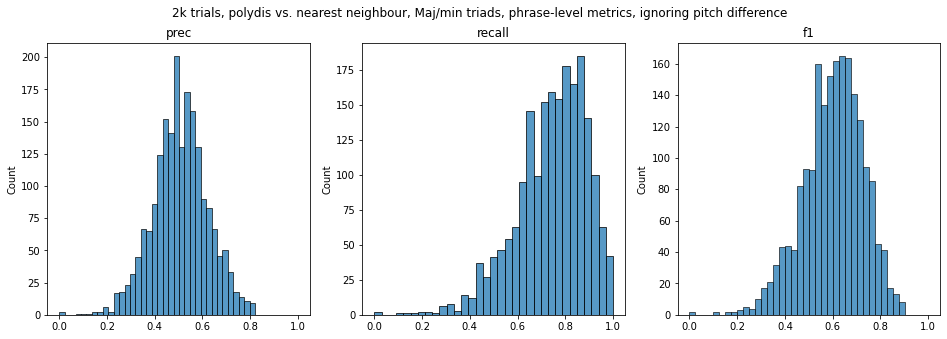

In [8]:
# Easy mode: only match timings
def prec_recall_f1_easy(pred, ref):
    hit = 0
    n_pred = len(pred)
    n_true = len(ref)
    for note in pred:
        start = note.start
        end = note.end
        pit = note.pitch
        eject_id = -1
        for idx, note_ref in enumerate(ref):
            if note_ref.start == start and note_ref.end == end:
                hit += 1
                eject_id = idx
                break
        if eject_id > -1:
            ref.pop(eject_id)
    if n_pred == 0:
        prec = 1e-10
    else:
        prec = hit / n_pred + 1e-10
    if n_true == 0 :
        recall = 1e-10
    else:
        recall = hit / n_true + 1e-10
    f1 = 2 / (1 / prec + 1 / recall)
    return prec, recall, f1

def run_trial():
    n_trial = 2000
    precs = []
    recalls = []
    f1s = []

    iter = 0
    while True:
        for batch in loader:
            iter += 1
            if iter > n_trial:
                break

            melody, pr, pr_mat, ptree, _ = batch
            pr_mat = pr_mat[0]
            chord = gen_chord()
            chord_ = chord.unsqueeze(0)
            _, notes = model.decoder.grid_to_pr_and_notes(ptree[0].squeeze(0).numpy().astype(int))

            polydis_out = model.swap(pr_mat.float(), pr_mat.float(), chord_.float(), chord_.float(), fix_rhy=True, fix_chd=False)
            _, notes_polydis = model.decoder.grid_to_pr_and_notes(polydis_out.squeeze(0).astype(int))
            notes_rule = hst_nn(notes, chord)
            
            prec, recall, f1 = prec_recall_f1_easy(notes_rule, notes_polydis)
            precs.append(prec)
            recalls.append(recall)
            f1s.append(f1)
        
        if iter > n_trial:
            break
    precs = np.array(precs)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    return precs, recalls, f1s

prec, recall, f1 = run_trial()
print(np.mean(prec), np.mean(recall), np.mean(f1))
out = {
    'prec': prec,
    'recall': recall,
    'f1': f1
}
torch.save(out, 'prec_recall_f1_easy.hi')
data = torch.load('./prec_recall_f1_easy.hi')

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(16,5))

fig.suptitle('2k trials, polydis vs. nearest neighbour, Maj/min triads, phrase-level metrics, ignoring pitch difference')
for idx, metric in enumerate(['prec', 'recall', 'f1']):
    sns.histplot(data[metric], ax=axes[idx])
    axes[idx].set_title(metric)